In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [150]:
df = pd.read_csv('../Health.csv')
df.shape

(170761, 42)

In [151]:
# тут я выводил количество nan, оказались они только в 1 столбце(верьте мне)
df.isna().sum();

In [152]:
df[df['sagey_b'].isna()]

,hhidpn,rmstat,ragender,rahispan,raracem,riwbegy,ragey_b,sagey_b,rhltc,rhlthlm,...,rjcten,index_wave,insured_gov,uninsured,retired,collegeplus,year,cpi,rgov,sgov
40359,42633021,1,1,0,3,15apr2006,53,NaN,3,1,...,.w,8,1,0,0,0,2005,1.133913,4680.0,10032.0
48942,48544011,1,1,0,1,15oct2006,46,NaN,3,1,...,1.9,8,0,0,0,0,2005,1.133913,0.0,0.0
85784,85066011,1,1,0,2,15apr2006,68,NaN,3,0,...,.w,8,1,0,100,0,2005,1.133913,7476.0,276.0
149436,500893010,3,2,0,1,15may2006,54,NaN,4,0,...,26.7,2,0,0,0,1,2005,1.133913,0.0,0.0


In [153]:
df['sagey_b'].fillna('.m', inplace=True)

In [154]:
df.duplicated().sum()

0

In [155]:
cnt_missing = 0

for col in df.columns:
    values = df[col].value_counts()

    if col == 'riwbegy':
        continue

    for value in values.index:
        try:
            _ = float(value)
        except ValueError:
            cnt_missing += values[value]

cnt_missing

398369

In [156]:
print(f'Процент пропущенных: {(cnt_missing / (df.shape[0] * df.shape[1]) * 100):.2f}%')

Процент пропущенных: 5.55%


In [157]:
def get_all_missing_codes(column):
    if column == 'riwbegy':
        return []
        
    unique_values = df[column].unique()
    codes = []

    for value in unique_values:
        try:
            _ = float(value)
        except ValueError:
            codes.append(value)

    return sorted(codes)

In [158]:
missing_codes = set()

for col in df.columns:
    missing_codes.update(get_all_missing_codes(col))

In [159]:
missing_codes

{'.c', '.d', '.e', '.m', '.p', '.r', '.s', '.t', '.u', '.v', '.w', '.y', '.z'}

In [160]:
def get_percent_of_missed(column):
    # count where value is in missing_codes
    count_of_missing = df[column].isin(missing_codes).sum()
    return count_of_missing, count_of_missing / df.shape[0] * 100

In [161]:
print('Кол-во пропущенных значений в столбцах(остальные полные):')
for col in df.columns:
    amount, percent = get_percent_of_missed(col)
    
    if amount > 0:
        print(f'{col}: {amount}({percent:.2f}%), коды: {get_all_missing_codes(col)}')

Кол-во пропущенных значений в столбцах(остальные полные):
rmstat: 114(0.07%), коды: ['.m']
rahispan: 105(0.06%), коды: ['.m']
raracem: 151(0.09%), коды: ['.m']
ragey_b: 2(0.00%), коды: ['.m']
sagey_b: 55695(32.62%), коды: ['.m', '.u', '.v']
rhltc: 15862(9.29%), коды: ['.d', '.m', '.p', '.r']
rhlthlm: 11987(7.02%), коды: ['.d', '.m', '.r', '.w', '.y']
rhibpe: 213(0.12%), коды: ['.d', '.m', '.r']
rdiabe: 228(0.13%), коды: ['.d', '.m', '.r']
rcancre: 315(0.18%), коды: ['.d', '.m', '.r', '.t']
rlunge: 151(0.09%), коды: ['.d', '.m', '.r']
rhearte: 197(0.12%), коды: ['.d', '.m', '.r']
rstroke: 129(0.08%), коды: ['.d', '.m', '.r']
rpsyche: 200(0.12%), коды: ['.d', '.m', '.r']
rarthre: 186(0.11%), коды: ['.d', '.m', '.r']
rhosp: 657(0.38%), коды: ['.d', '.m', '.r']
rhspnit: 1391(0.81%), коды: ['.d', '.m', '.r', '.z']
rcovr: 2832(1.66%), коды: ['.c', '.d', '.e', '.m', '.r', '.t']
rcovs: 2274(1.33%), коды: ['.c', '.d', '.e', '.m', '.r', '.t']
rjphys: 101085(59.20%), коды: ['.d', '.m', '.p', '.r'

In [162]:
import datetime

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

def parse_date(el):
    day, month, year = el[:2], el[2:5], el[5:]

    return datetime.date(int(year), months.index(month) + 1, int(day))


df['riwbegy'] = df['riwbegy'].apply(parse_date)
df['riwbegy'] = pd.to_datetime(df['riwbegy'])
df['inter_year'] = df['riwbegy'].dt.year

In [163]:
def to_int(el):
    try:
        return int(el)
    except ValueError:
        return np.nan


def apply_missing(el):
    try:
        _ = float(el)
        return el
    except ValueError:
        return '.m'

In [164]:
# заменим все коды пропусков на .m

for col in df.columns:
    if col != 'riwbegy':
        df[col] = df[col].apply(apply_missing)

In [165]:
df_without_missed_ragey_b = df[df['ragey_b'] != '.m'];
df_without_missed_ragey_b['ragey_b'] = df_without_missed_ragey_b['ragey_b'].astype(int);

median_age_by_wave = df_without_missed_ragey_b.groupby('index_wave')['ragey_b'].median();

In [166]:
def fill_missing_ragey_b(el):
    if el['ragey_b'] == '.m':
        return median_age_by_wave[el['index_wave']]
    else:
        return el['ragey_b']

df['ragey_b'] = df.apply(fill_missing_ragey_b, axis=1)
df['ragey_b'] = df['ragey_b'].astype(int)

df['year_of_birth'] = df['riwbegy'].dt.year - df['ragey_b']

In [167]:
df['total_work_earn'] = df['riearn'] + df['siearn']
df['total_pension_earn'] = df['ripena'] + df['sipena']
df['total_gov_income'] = df['rgov'] + df['sgov']

df['total_income'] = df['total_work_earn'] + df['total_pension_earn'] + df['total_gov_income']

In [168]:
df['total_income'].describe()

count    1.707610e+05
mean     4.449124e+04
std      5.282410e+04
min      0.000000e+00
25%      1.519674e+04
50%      2.991608e+04
75%      5.718045e+04
max      6.875386e+06
Name: total_income, dtype: float64

In [169]:
# а тут меня очень смущает максимум в столбце sipena, мб это выброс
df.iloc[:, 21:25].describe()

,riearn,ripena,siearn,sipena
count,170761.000000,170761.000000,170761.000000,1.707610e+05
mean,15702.244733,3764.862189,12042.235232,2.579190e+03
std,33371.000325,12092.210896,30816.336503,2.217670e+04
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000e+00
75%,21089.415692,0.000000,8000.000000,0.000000e+00
max,643233.038611,319329.942983,615098.104813,6.780589e+06


In [170]:
df.to_csv('../Health_cleaned.csv', index=False)

In [171]:
without_work = df[df['riearn'] == 0]['hhidpn'].unique()

In [172]:
got_or_lost_work = []

for respondent_id in without_work:
    if df[df['hhidpn'] == respondent_id]['riearn'].nunique() > 1:
        got_or_lost_work.append(respondent_id)

len(got_or_lost_work)

11651

In [173]:
got_or_lost_work[:10]

[3010,
 3020,
 10001010,
 10003020,
 10004040,
 10013010,
 10013040,
 10038010,
 10059030,
 10063010]

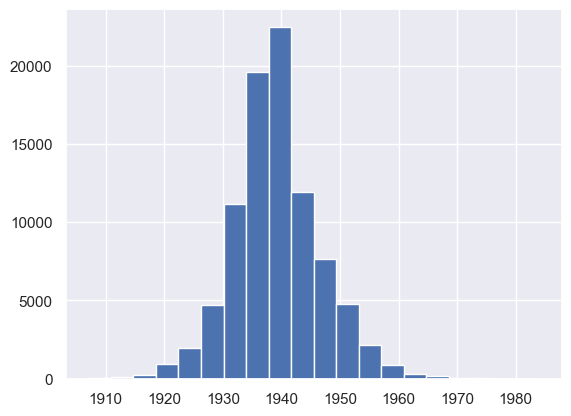

In [181]:
# histogram of year_of_birth of respondents who lost or got work
sns.set()
df[df['hhidpn'].isin(got_or_lost_work)]['year_of_birth'].hist(bins=20)

plt.show()

In [177]:
df[df['hhidpn'] == 10063010].sort_values('riwbegy')

,hhidpn,rmstat,ragender,rahispan,raracem,riwbegy,ragey_b,sagey_b,rhltc,rhlthlm,...,year,cpi,rgov,sgov,inter_year,year_of_birth,total_work_earn,total_pension_earn,total_gov_income,total_income
142,10063010,4,2,1,2,1992-10-16,54,.m,3,1,...,1991,0.811126,3830.3835,0.0,1992,1938,0.000000,0.0,3830.3835,3830.383500
140,10063010,5,2,1,2,1994-08-30,56,.m,4,1,...,1993,0.852219,3831.9592,0.0,1994,1938,0.000000,0.0,3831.9592,3831.959200
144,10063010,6,2,1,2,1996-06-15,58,.m,4,1,...,1995,0.891173,1825.8684,0.0,1996,1938,20358.114117,0.0,1825.8684,22183.982517
145,10063010,5,2,1,2,2004-12-15,66,.m,3,0,...,2003,1.068196,2104.9963,0.0,2004,1938,0.000000,0.0,2104.9963,2104.996300
143,10063010,4,2,1,2,2006-06-15,68,.m,2,0,...,2005,1.133913,10344.0000,0.0,2006,1938,0.000000,0.0,10344.0000,10344.000000
139,10063010,5,2,1,2,2011-03-15,73,.m,2,0,...,2010,1.266227,9177.1377,0.0,2011,1938,0.000000,0.0,9177.1377,9177.137700
141,10063010,7,2,1,2,2012-07-15,74,.m,3,.m,...,2011,1.306293,7508.5371,0.0,2012,1938,0.000000,0.0,7508.5371,7508.537100
